# Narrowband Signal Localization for SETI on Noisy Synthetic Spectrogram Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# basic cnn training
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import multi_gpu_model, to_categorical

import keras
import tensorflow as tf

import numpy as np
import os, sys, errno

import csv
import codecs
import pickle
import h5py

import sys, os, glob

dir_name = prefix = '/datax/scratch/bbrzycki/training/training2/'

db_num = 6
dbs = [i * 5 for i in range(db_num)]

per_db = 4000

Using TensorFlow backend.


# Only one signal

In [2]:
h5_datasets = '/datax/scratch/bbrzycki/training/training2/data/1sig/1sig.hdf5'

sig_shape = (db_num, per_db, 2)
all_labels = np.zeros(sig_shape)

with h5py.File(h5_datasets, 'r') as f:
    for i in range(db_num):
        sig_db = i * 5
        
        for j in range(per_db):
            ID_int = i * per_db + j
    
            ID = '%06d' % ID_int
        
            class_nums = f['test'][ID].attrs['class_nums']
            this_db = f['test'][ID].attrs['sig_db']
            assert sig_db == this_db

            start_index, end_index, line_width, snr, class_label = np.squeeze(f['test'][ID]['signals_info'])
            # All between 0 and 1
            labels = np.array([start_index / 1024, end_index / 1024])
            all_labels[i, j, :] = labels
            
all_labels.shape

(6, 4000, 2)

In [29]:
np.save('train/1sig/all_labels.npy', all_labels)

In [262]:
all_labels = np.load('train/1sig/all_labels.npy')

### Simple CNN

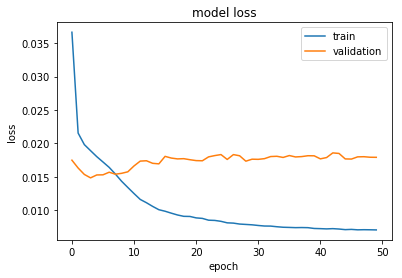

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

# model.summary()

#################################################################

model_fn = dir_name + 'models/1sig/simple_cnn.h5'
history_fn = dir_name + 'models/1sig/simple_cnn_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [5]:
simple_cnn_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
        frame = np.load(filename)
        X = np.copy(frame).reshape((1, 32, 1024, 1))
        X -= np.mean(X)
        X /= np.std(X)
        
        predictions = model.predict(X)[0]
        
        simple_cnn_predictions[i, j, :] = predictions
        
simple_cnn_predictions.shape

(6, 4000, 2)

In [26]:
np.save('train/1sig/simple_cnn_predictions.npy', simple_cnn_predictions)

In [263]:
simple_cnn_predictions = np.load('train/1sig/simple_cnn_predictions.npy')

In [6]:
simple_cnn_errors = np.mean(np.mean((all_labels - simple_cnn_predictions)**2, axis=2), axis=1)
simple_cnn_errors.shape

(6,)

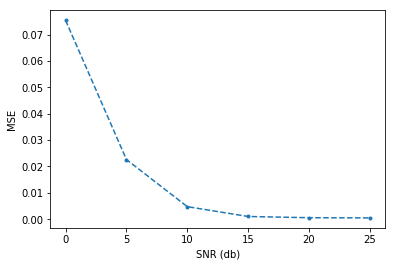

In [7]:
plt.plot(dbs, simple_cnn_errors, '--.')
plt.xlabel('SNR (db)')
plt.ylabel('MSE')
plt.show()

### ResNet

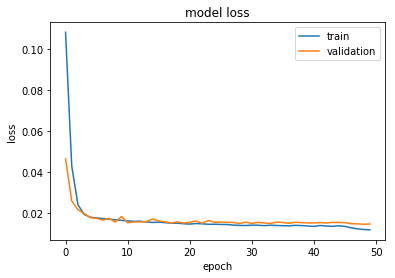

In [12]:
from keras.layers import Conv2D, Input, Dense, BatchNormalization
from keras.models import Model

activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 1))
# 3x3 conv with 3 output channels (same as input channels)
r0 = Residual(inputs, 32)
strided0 = Conv2D(32, (3, 3), strides=2)(r0)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(64, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 64)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
dense1 = Dense(64, activation=activation)(dense0)
drop0 = Dropout(0.5)(dense1)
predictions = Dense(2, activation='linear')(drop0)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

#################################################################

model_fn = dir_name + 'models/1sig/%s_resnet.h5' % activation
history_fn = dir_name + 'models/1sig/%s_resnet_history' % activation

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [13]:
resnet_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
        frame = np.load(filename)
        X = np.copy(frame).reshape((1, 32, 1024, 1))
        X -= np.mean(X)
        X /= np.std(X)
        
        predictions = model.predict(X)[0]
        
        resnet_predictions[i, j, :] = predictions
        
resnet_predictions.shape

(6, 4000, 2)

In [27]:
np.save('train/1sig/resnet_predictions.npy', resnet_predictions)

In [14]:
resnet_errors = np.mean(np.mean((all_labels - resnet_predictions)**2, axis=2), axis=1)
resnet_errors.shape

(6,)

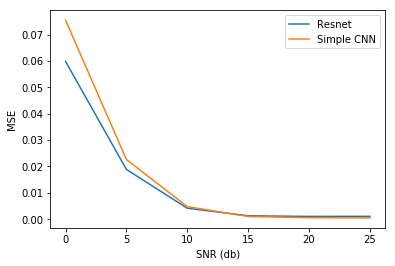

In [17]:
plt.plot(dbs, resnet_errors, label='Resnet')
plt.plot(dbs, simple_cnn_errors, label='Simple CNN')
plt.xlabel('SNR (db)')
plt.ylabel('MSE')
plt.legend()
plt.show()

### ResNet 2 Channels

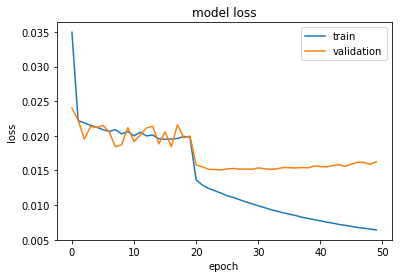

In [6]:
from keras.layers import Conv2D, Conv3D, Input, Dense
from keras.models import Model

activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 2))
# 3x3 conv with 3 output channels (same as input channels)

strided0 = Conv2D(32, (3, 3), strides=2)(inputs)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
d = Dense(2048, activation=activation)(dense0)
d = Dropout(0.5)(d)
predictions = Dense(2, activation='linear')(d)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model_fn = dir_name + 'models/1sig/resnet_2chans.h5'
history_fn = dir_name + 'models/1sig/resnet_2chans_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [19]:
resnet_2chans_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)

        X1 -= np.mean(X1)
        X1 /= np.std(X1)

        X2 -= np.mean(X2, axis=0)
        X2 /= np.std(X2, axis=0)

        Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))
        
        predictions = model.predict(Xstack)[0]
        
        resnet_2chans_predictions[i, j, :] = predictions
        
resnet_2chans_predictions.shape

(6, 4000, 2)

In [28]:
np.save('train/1sig/resnet_2chans_predictions.npy', resnet_2chans_predictions)

In [264]:
resnet_2chans_predictions = np.load('train/1sig/resnet_2chans_predictions.npy')

In [20]:
resnet_2chans_errors = np.mean(np.mean((all_labels - resnet_2chans_predictions)**2, axis=2), axis=1)
resnet_2chans_errors.shape

(6,)

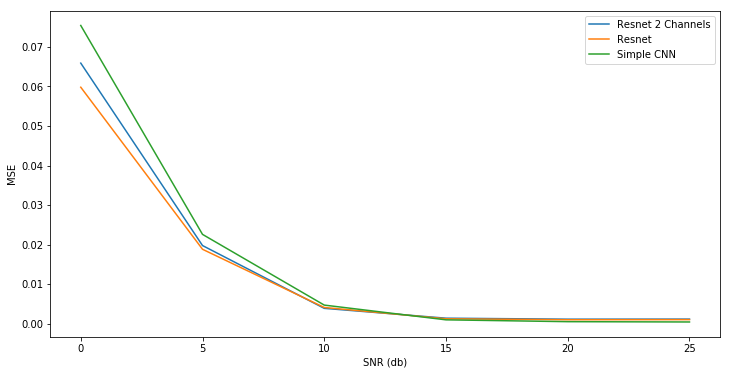

In [22]:
fig = plt.figure(figsize=(12,6))
plt.plot(dbs, resnet_2chans_errors, label='Resnet 2 Channels')
plt.plot(dbs, resnet_errors, label='Resnet')
plt.plot(dbs, simple_cnn_errors, label='Simple CNN')
plt.xlabel('SNR (db)')
plt.ylabel('MSE')
plt.legend()
plt.show()

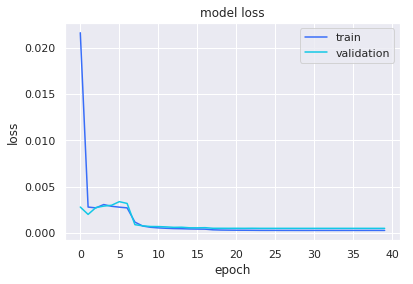

In [266]:
sig_shape = (db_num, per_db, 2)


from keras.layers import Conv2D, Conv3D, Input, Dense, BatchNormalization
from keras.models import Model
keras.backend.clear_session()
activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 2))
# 3x3 conv with 3 output channels (same as input channels)

strided0 = Conv2D(32, (3, 3), strides=2, activation=activation)(inputs)
# strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2, activation=activation)(r1)
# strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2, activation=activation)(r2)
# strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
d = Dense(2048, activation=activation)(dense0)
d = Dropout(0.5)(d)
predictions = Dense(2, activation='linear')(d)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model_fn = dir_name + 'models/1sig/resnet_2chans_bright.h5'
history_fn = dir_name + 'models/1sig/resnet_2chans_bright_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


resnet_2chans_bright_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)

        X1 -= np.mean(X1)
        X1 /= np.std(X1)

        X2 -= np.mean(X2, axis=0)
        X2 /= np.std(X2, axis=0)

        Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))
        
        predictions = model.predict(Xstack)[0]
        
        resnet_2chans_bright_predictions[i, j, :] = predictions
        
np.save('train/1sig/resnet_2chans_bright_predictions.npy', resnet_2chans_bright_predictions)

resnet_2chans_bright_errors = np.mean(np.mean((all_labels - resnet_2chans_bright_predictions)**2, axis=2), axis=1)

resnet_2chans_bright_errors_keep_dims = np.mean((all_labels - resnet_2chans_bright_predictions)**2, axis=2)

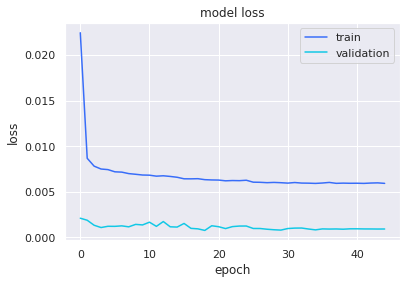

In [271]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

# model.summary()

#################################################################

model_fn = dir_name + 'models/1sig/simple_cnn_bright.h5'
history_fn = dir_name + 'models/1sig/simple_cnn_bright_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


simple_cnn_bright_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
        frame = np.load(filename)
        X = np.copy(frame).reshape((1, 32, 1024, 1))
        X -= np.mean(X)
        X /= np.std(X)
        
        predictions = model.predict(X)[0]
        
        simple_cnn_bright_predictions[i, j, :] = predictions
        
np.save('train/1sig/simple_cnn_bright_predictions.npy', simple_cnn_bright_predictions)

simple_cnn_bright_errors = np.mean(np.mean((all_labels - simple_cnn_bright_predictions)**2, axis=2), axis=1)

simple_cnn_bright_errors_keep_dims = np.mean((all_labels - simple_cnn_bright_predictions)**2, axis=2)

In [272]:
simple_cnn_errors_keep_dims = np.mean((all_labels - simple_cnn_predictions)**2, axis=2)
resnet_2chans_errors_keep_dims = np.mean((all_labels - resnet_2chans_predictions)**2, axis=2)


d = {'db': [], 'mse': [], 'rmse_index': [], 'model': []}
for i in range(6):
    for j in range(4000):
        d['db'].append(i * 5)
        d['mse'].append(simple_cnn_errors_keep_dims[i, j])
        d['rmse_index'].append(simple_cnn_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Baseline')
        
        d['db'].append(i * 5)
        d['mse'].append(simple_cnn_bright_errors_keep_dims[i, j])
        d['rmse_index'].append(simple_cnn_bright_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Baseline Bright')
        
        
        d['db'].append(i * 5)
        d['mse'].append(resnet_2chans_errors_keep_dims[i, j])
        d['rmse_index'].append(resnet_2chans_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final')
        
        
        d['db'].append(i * 5)
        d['mse'].append(resnet_2chans_bright_errors_keep_dims[i, j])
        d['rmse_index'].append(resnet_2chans_bright_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final Bright')
        

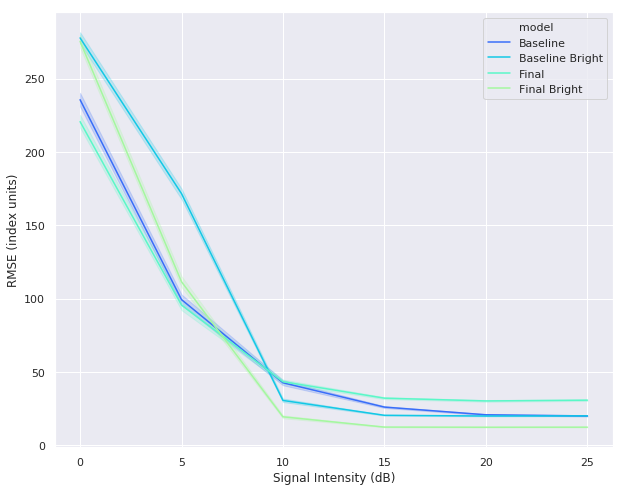

In [273]:
df = pd.DataFrame(data=d)

fig = plt.figure(figsize=(10, 8))
sns.lineplot(x='db', y='rmse_index', hue='model', data=df)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')
plt.show()

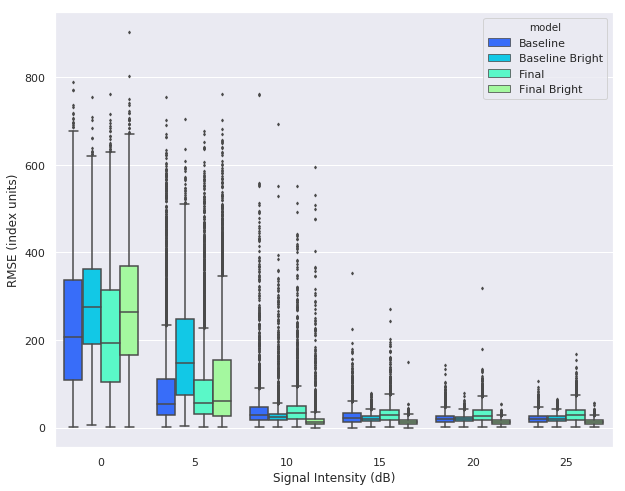

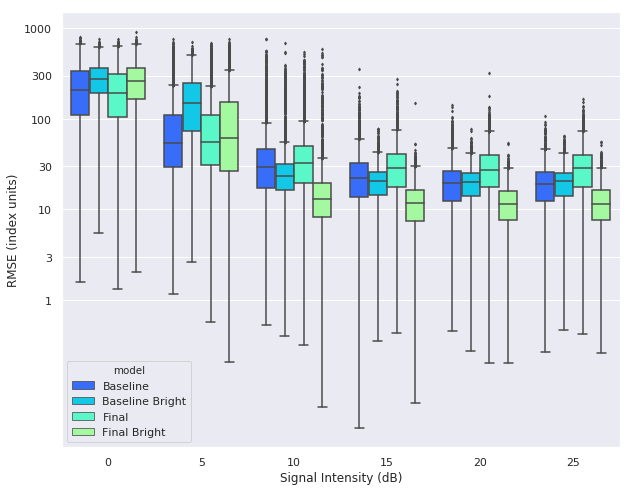

In [274]:
import matplotlib.ticker as ticker

df = pd.DataFrame(data=d)

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

# plt.ylim(0, 500)
# ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

df = pd.DataFrame(data=d)

import matplotlib.ticker as ticker

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

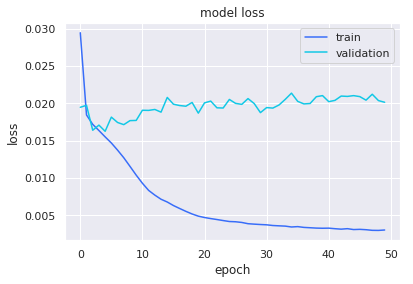

In [290]:
all_labels = np.load('train/1sig/all_labels.npy')
sig_shape = (db_num, per_db, 2)

from keras.layers import Conv2D, Conv3D, Input, Dense
from keras.models import Model

activation = 'relu'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 2))
# 3x3 conv with 3 output channels (same as input channels)

strided0 = Conv2D(32, (3, 3), strides=2)(inputs)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
d = Dense(2048, activation=activation)(dense0)
d = Dropout(0.5)(d)
predictions = Dense(2, activation='linear')(d)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

#################################################################

model_fn = dir_name + 'models/1sig/relu_resnet_2chans.h5'
history_fn = dir_name + 'models/1sig/relu_resnet_2chans_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


relu_resnet_2chans_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)

        X1 -= np.mean(X1)
        X1 /= np.std(X1)

        X2 -= np.mean(X2, axis=0)
        X2 /= np.std(X2, axis=0)

        Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))
        
        predictions = model.predict(Xstack)[0]
        
        relu_resnet_2chans_predictions[i, j, :] = predictions
        
np.save('train/1sig/relu_resnet_2chans_predictions.npy', relu_resnet_2chans_predictions)

relu_resnet_2chans_errors = np.mean(np.mean((all_labels - relu_resnet_2chans_predictions)**2, axis=2), axis=1)

relu_resnet_2chans_errors_keep_dims = np.mean((all_labels - relu_resnet_2chans_predictions)**2, axis=2)

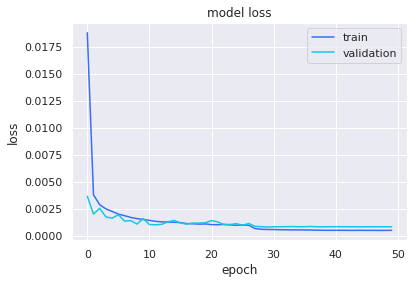

In [291]:
all_labels = np.load('train/1sig/all_labels.npy')
sig_shape = (db_num, per_db, 2)

from keras.layers import Conv2D, Conv3D, Input, Dense
from keras.models import Model

activation = 'relu'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 2))
# 3x3 conv with 3 output channels (same as input channels)

strided0 = Conv2D(32, (3, 3), strides=2)(inputs)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
d = Dense(2048, activation=activation)(dense0)
d = Dropout(0.5)(d)
predictions = Dense(2, activation='linear')(d)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

#################################################################

model_fn = dir_name + 'models/1sig/relu_resnet_2chans_bright.h5'
history_fn = dir_name + 'models/1sig/relu_resnet_2chans_bright_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


relu_resnet_2chans_bright_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)

        X1 -= np.mean(X1)
        X1 /= np.std(X1)

        X2 -= np.mean(X2, axis=0)
        X2 /= np.std(X2, axis=0)

        Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))
        
        predictions = model.predict(Xstack)[0]
        
        relu_resnet_2chans_bright_predictions[i, j, :] = predictions
        
np.save('train/1sig/relu_resnet_2chans_bright_predictions.npy', relu_resnet_2chans_bright_predictions)

relu_resnet_2chans_bright_errors = np.mean(np.mean((all_labels - relu_resnet_2chans_bright_predictions)**2, axis=2), axis=1)

relu_resnet_2chans_bright_errors_keep_dims = np.mean((all_labels - relu_resnet_2chans_bright_predictions)**2, axis=2)

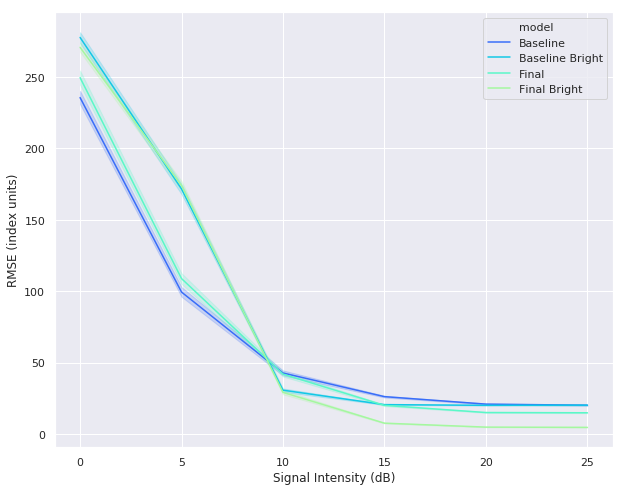

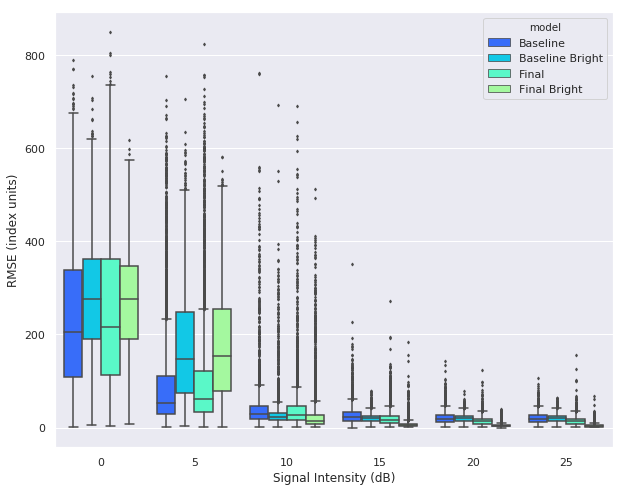

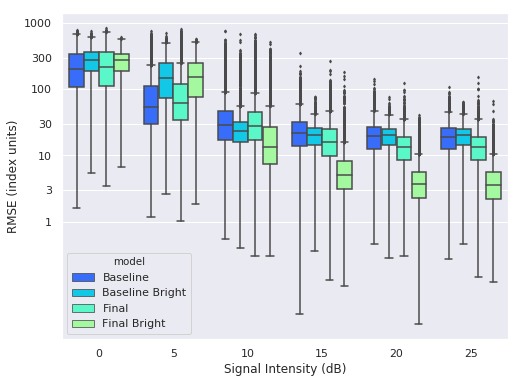

In [292]:
all_labels = np.load('train/1sig/all_labels.npy')
simple_cnn_predictions = np.load('train/1sig/simple_cnn_predictions.npy')
simple_cnn_bright_predictions = np.load('train/1sig/simple_cnn_bright_predictions.npy')
relu_resnet_2chans_predictions = np.load('train/1sig/relu_resnet_2chans_predictions.npy')
relu_resnet_2chans_bright_predictions = np.load('train/1sig/relu_resnet_2chans_bright_predictions.npy')

simple_cnn_errors_keep_dims = np.mean((all_labels - simple_cnn_predictions)**2, axis=2)
simple_cnn_bright_errors_keep_dims = np.mean((all_labels - simple_cnn_bright_predictions)**2, axis=2)
relu_resnet_2chans_errors_keep_dims = np.mean((all_labels - relu_resnet_2chans_predictions)**2, axis=2)
relu_resnet_2chans_bright_errors_keep_dims = np.mean((all_labels - relu_resnet_2chans_bright_predictions)**2, axis=2)

d = {'db': [], 'mse': [], 'rmse_index': [], 'model': []}
for i in range(6):
    for j in range(4000):
        d['db'].append(i * 5)
        d['mse'].append(simple_cnn_errors_keep_dims[i, j])
        d['rmse_index'].append(simple_cnn_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Baseline')
        
        d['db'].append(i * 5)
        d['mse'].append(simple_cnn_bright_errors_keep_dims[i, j])
        d['rmse_index'].append(simple_cnn_bright_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Baseline Bright')
        
        d['db'].append(i * 5)
        d['mse'].append(relu_resnet_2chans_errors_keep_dims[i, j])
        d['rmse_index'].append(relu_resnet_2chans_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final')
        
        d['db'].append(i * 5)
        d['mse'].append(relu_resnet_2chans_bright_errors_keep_dims[i, j])
        d['rmse_index'].append(relu_resnet_2chans_bright_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final Bright')
    
df = pd.DataFrame(data=d)

fig = plt.figure(figsize=(10, 8))
sns.lineplot(x='db', y='rmse_index', hue='model', data=df)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')
plt.show()

import matplotlib.ticker as ticker

df = pd.DataFrame(data=d)

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

# plt.ylim(0, 500)
# ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

df = pd.DataFrame(data=d)

import matplotlib.ticker as ticker

sns.set(palette="rainbow")
fig = plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.savefig('1sig_rmse.pdf', bbox_inches='tight')
plt.show()

### Extra

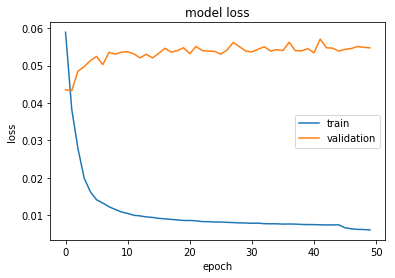

In [24]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='linear'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

# model.summary()

#################################################################

model_fn = dir_name + 'models/1sig/simple_cnn_lowsnr.h5'
history_fn = dir_name + 'models/1sig/simple_cnn_lowsnr_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

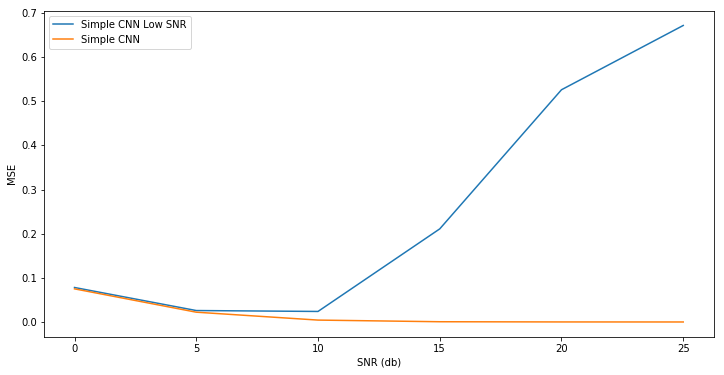

In [25]:
simple_cnn_lowsnr_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/1sig/test/%s.npy' % ID
        frame = np.load(filename)
        X = np.copy(frame).reshape((1, 32, 1024, 1))
        X -= np.mean(X)
        X /= np.std(X)
        
        predictions = model.predict(X)[0]
        
        simple_cnn_lowsnr_predictions[i, j, :] = predictions
        
simple_cnn_lowsnr_errors = np.mean(np.mean((all_labels - simple_cnn_lowsnr_predictions)**2, axis=2), axis=1)

fig = plt.figure(figsize=(12,6))
plt.plot(dbs, simple_cnn_lowsnr_errors, label='Simple CNN Low SNR')
plt.plot(dbs, simple_cnn_errors, label='Simple CNN')
plt.xlabel('SNR (db)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [3]:
sig_shape = (db_num, per_db, 4)

In [4]:
h5_datasets = '/datax/scratch/bbrzycki/training/training2/data/2sig/2sig.hdf5'

# Two signals

In [ ]:
h5_datasets = '/datax/scratch/bbrzycki/training/training2/data/2sig/2sig.hdf5'

sig_shape = (db_num, per_db, 4)
all_labels = np.zeros(sig_shape)

with h5py.File(h5_datasets, 'r') as f:
    for i in range(db_num):
        sig_db = i * 5
        
        for j in range(per_db):
            ID_int = i * per_db + j
    
            ID = '%06d' % ID_int
        
            class_nums = f['test'][ID].attrs['class_nums']
            this_db = f['test'][ID].attrs['sig_db']
            assert sig_db == this_db

            start1, end1, lw1, snr1, label1, start2, end2, lw2, snr2, label2  = np.array(f['test'][ID]['signals_info']).flatten()
            # All between 0 and 1
            labels = np.array([start1 / 1024, end1 / 1024, start2 / 1024, end2 / 1024])
            all_labels[i, j, :] = labels
            
all_labels.shape

In [78]:
np.save('train/2sig/all_labels.npy', all_labels)

In [2]:
all_labels = np.load('train/2sig/all_labels.npy')

### Simple CNN

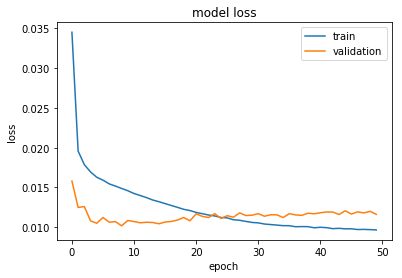

In [2]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 1024, 1)))
# model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Activation('relu'))

model.add(Dense(64, activation='relu'))
# model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='linear'))

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model_fn = dir_name + 'models/2sig/simple_cnn.h5'
history_fn = dir_name + 'models/2sig/simple_cnn_history'

from keras.utils import plot_model
plot_model(model, to_file='2sig_simple_cnn.pdf', show_shapes=False)

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [53]:
simple_cnn_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
        frame = np.load(filename)
        X = np.copy(frame).reshape((1, 32, 1024, 1))
        X -= np.mean(X)
        X /= np.std(X)
        
        predictions = model.predict(X)[0]
        
        simple_cnn_predictions[i, j, :] = predictions
        
simple_cnn_predictions.shape

(6, 4000, 4)

In [79]:
all_labels[:, 0, :] * 1024

array([[899., 899., 239., 650.],
       [281., 281., 941., 986.],
       [527., 527., 548., 679.],
       [443., 443., 983., 579.],
       [662., 662., 131., 585.],
       [753., 753., 823., 986.]])

In [80]:
simple_cnn_predictions[:, 0, :] * 1024

array([[ 877.74499512,  877.74505615,  307.01370239,  520.72320557],
       [ 285.50927734,  285.50927734, 1067.96630859, 1168.56713867],
       [ 522.80163574,  522.80157471,  505.24761963,  667.22198486],
       [ 443.67919922,  443.6791687 ,  973.55755615,  557.20056152],
       [ 648.09503174,  648.0949707 ,   87.27578735,  561.92486572],
       [ 733.52130127,  733.5213623 ,  786.98571777,  990.38000488]])

In [81]:
np.save('train/2sig/simple_cnn_predictions.npy', simple_cnn_predictions)

In [276]:
simple_cnn_predictions = np.load('train/2sig/simple_cnn_predictions.npy')

In [82]:
simple_cnn_errors = np.mean(np.mean((all_labels - simple_cnn_predictions)**2, axis=2), axis=1)
simple_cnn_errors.shape

(6,)

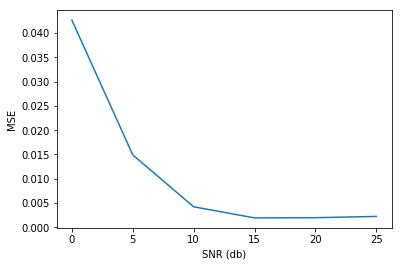

In [83]:
plt.plot(dbs, simple_cnn_errors)
plt.xlabel('SNR (db)')
plt.ylabel('MSE')
plt.show()

### ResNet

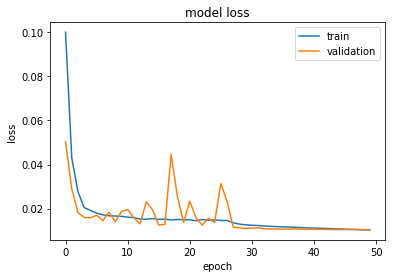

In [57]:
from keras.layers import Conv2D, Input, Dense, BatchNormalization
from keras.models import Model

activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 1))
# 3x3 conv with 3 output channels (same as input channels)
r0 = Residual(inputs, 32)
strided0 = Conv2D(32, (3, 3), strides=2)(r0)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(64, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 64)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
dense1 = Dense(64, activation=activation)(dense0)
drop0 = Dropout(0.5)(dense1)
predictions = Dense(4, activation='linear')(drop0)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model_fn = dir_name + 'models/2sig/%s_resnet.h5' % activation
history_fn = dir_name + 'models/2sig/%s_resnet_history' % activation

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [58]:
resnet_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
        frame = np.load(filename)
        X = np.copy(frame).reshape((1, 32, 1024, 1))
        X -= np.mean(X)
        X /= np.std(X)
        
        predictions = model.predict(X)[0]
        
        resnet_predictions[i, j, :] = predictions
        
resnet_predictions.shape

(6, 4000, 4)

In [84]:
np.save('train/2sig/resnet_predictions.npy', resnet_predictions)

In [85]:
resnet_errors = np.mean(np.mean((all_labels - resnet_predictions)**2, axis=2), axis=1)
resnet_errors.shape

(6,)

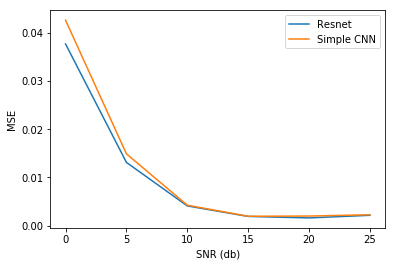

In [86]:
plt.plot(dbs, resnet_errors, label='Resnet')
plt.plot(dbs, simple_cnn_errors, label='Simple CNN')
plt.xlabel('SNR (db)')
plt.ylabel('MSE')
plt.legend()
plt.show()

### ResNet 2 Channels

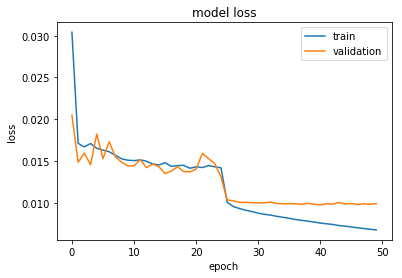

In [2]:
from keras.layers import Conv2D, Conv3D, Input, Dense, BatchNormalization
from keras.models import Model
keras.backend.clear_session()
activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 2))
# 3x3 conv with 3 output channels (same as input channels)

strided0 = Conv2D(32, (3, 3), strides=2, activation=activation)(inputs)
# strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2, activation=activation)(r1)
# strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2, activation=activation)(r2)
# strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
d = Dense(2048, activation=activation)(dense0)
d = Dropout(0.5)(d)
predictions = Dense(4, activation='linear')(d)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model_fn = dir_name + 'models/2sig/resnet_2chans.h5'
history_fn = dir_name + 'models/2sig/resnet_2chans_history'

from keras.utils import plot_model
plot_model(model, to_file='2sig_resnet_2chans.pdf', show_shapes=False)

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [63]:
resnet_2chans_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)

        X1 -= np.mean(X1)
        X1 /= np.std(X1)

        X2 -= np.mean(X2, axis=0)
        X2 /= np.std(X2, axis=0)

        Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))
        
        predictions = model.predict(Xstack)[0]
        
        resnet_2chans_predictions[i, j, :] = predictions
        
resnet_2chans_predictions.shape

(6, 4000, 4)

In [87]:
np.save('train/2sig/resnet_2chans_predictions.npy', resnet_2chans_predictions)

In [277]:
resnet_2chans_predictions = np.load('train/2sig/resnet_2chans_predictions.npy')

In [48]:
resnet_2chans_errors = np.mean(np.mean((all_labels - resnet_2chans_predictions)**2, axis=2), axis=1)
resnet_2chans_errors.shape

(6,)

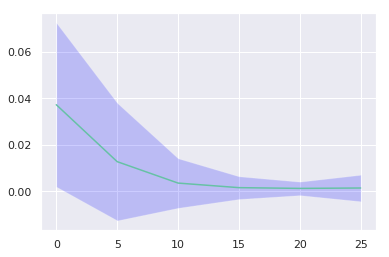

In [102]:
import seaborn as sns
import pandas as pd
resnet_2chans_errors_keep_dims = np.mean((all_labels - resnet_2chans_predictions)**2, axis=2)
error_means = np.mean(resnet_2chans_errors_keep_dims, axis=1)
error_stds = np.std(resnet_2chans_errors_keep_dims, axis=1)
plt.fill_between(dbs, error_means - error_stds, error_means + error_stds, alpha=0.2,facecolor='b')

sns.set(palette="Set2")
plt.plot(dbs, resnet_2chans_errors)
plt.show()

In [104]:
resnet_2chans_errors_keep_dims = np.mean((all_labels - resnet_2chans_predictions)**2, axis=2)
resnet_2chans_errors_keep_dims.shape

(6, 4000)

In [147]:
simple_cnn_errors_keep_dims = np.mean((all_labels - simple_cnn_predictions)**2, axis=2)
simple_cnn_errors_keep_dims.shape

(6, 4000)

In [166]:
d = {'db': [], 'mse': [], 'rmse_index': [], 'model': []}
for i in range(6):
    for j in range(4000):
        d['db'].append(i * 5)
        d['mse'].append(simple_cnn_errors_keep_dims[i, j])
        d['rmse_index'].append(simple_cnn_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Baseline')
        
        
        d['db'].append(i * 5)
        d['mse'].append(resnet_2chans_errors_keep_dims[i, j])
        d['rmse_index'].append(resnet_2chans_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final')
        
        


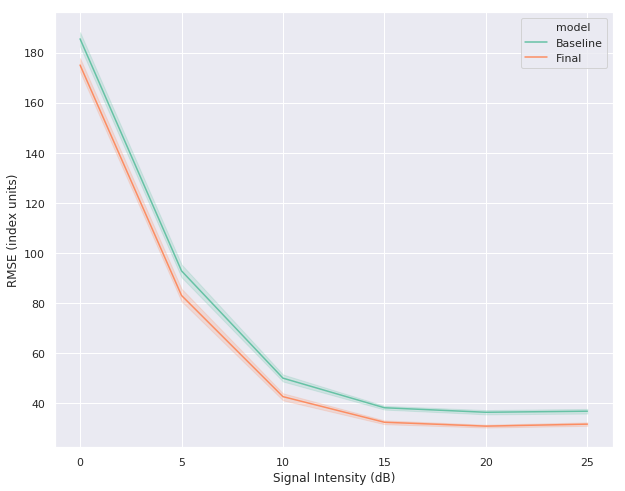

In [169]:
df = pd.DataFrame(data=d)

fig = plt.figure(figsize=(10, 8))
sns.lineplot(x='db', y='rmse_index', hue='model', data=df)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')
plt.show()

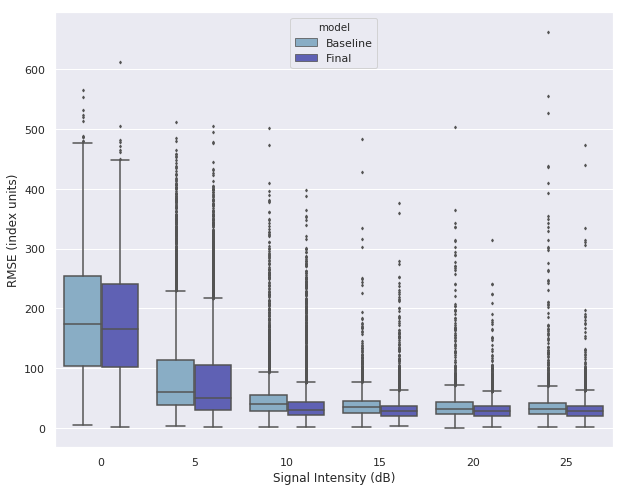

In [222]:
import matplotlib.ticker as ticker

df = pd.DataFrame(data=d)

sns.set(palette="twilight")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

# plt.ylim(0, 500)
# ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

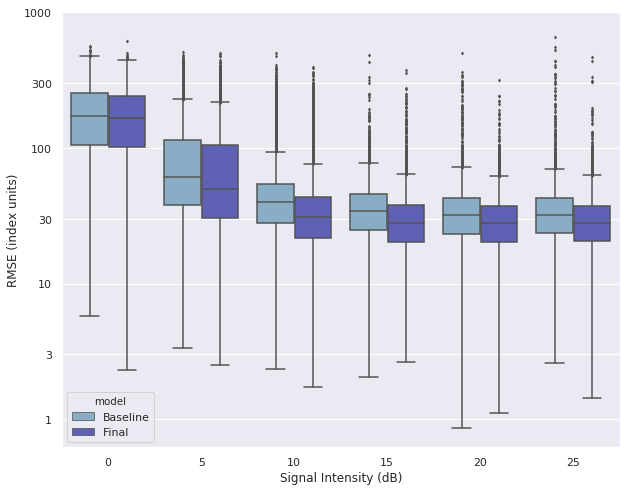

In [214]:
df = pd.DataFrame(data=d)

import matplotlib.ticker as ticker

sns.set(palette="twilight")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

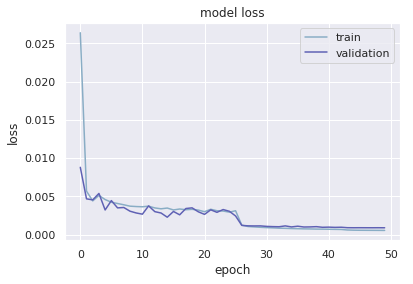

In [225]:
from keras.layers import Conv2D, Conv3D, Input, Dense, BatchNormalization
from keras.models import Model
keras.backend.clear_session()
activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 2))
# 3x3 conv with 3 output channels (same as input channels)

strided0 = Conv2D(32, (3, 3), strides=2, activation=activation)(inputs)
# strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2, activation=activation)(r1)
# strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2, activation=activation)(r2)
# strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
d = Dense(2048, activation=activation)(dense0)
d = Dropout(0.5)(d)
predictions = Dense(4, activation='linear')(d)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model_fn = dir_name + 'models/2sig/resnet_2chans_bright.h5'
history_fn = dir_name + 'models/2sig/resnet_2chans_bright_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


resnet_2chans_bright_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)

        X1 -= np.mean(X1)
        X1 /= np.std(X1)

        X2 -= np.mean(X2, axis=0)
        X2 /= np.std(X2, axis=0)

        Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))
        
        predictions = model.predict(Xstack)[0]
        
        resnet_2chans_bright_predictions[i, j, :] = predictions
        
np.save('train/2sig/resnet_2chans_bright_predictions.npy', resnet_2chans_bright_predictions)

resnet_2chans_bright_errors = np.mean(np.mean((all_labels - resnet_2chans_bright_predictions)**2, axis=2), axis=1)

resnet_2chans_bright_errors_keep_dims = np.mean((all_labels - resnet_2chans_bright_predictions)**2, axis=2)

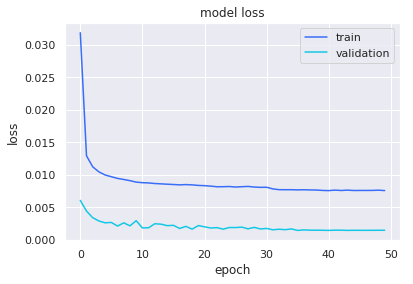

In [241]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 1024, 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='linear'))

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model_fn = dir_name + 'models/2sig/simple_cnn_bright.h5'
history_fn = dir_name + 'models/2sig/simple_cnn_bright_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


simple_cnn_bright_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
        frame = np.load(filename)
        X = np.copy(frame).reshape((1, 32, 1024, 1))
        X -= np.mean(X)
        X /= np.std(X)
        
        predictions = model.predict(X)[0]
        
        simple_cnn_bright_predictions[i, j, :] = predictions
        
np.save('train/2sig/simple_cnn_bright_predictions.npy', simple_cnn_bright_predictions)

simple_cnn_bright_errors = np.mean(np.mean((all_labels - simple_cnn_bright_predictions)**2, axis=2), axis=1)

simple_cnn_bright_errors_keep_dims = np.mean((all_labels - simple_cnn_bright_predictions)**2, axis=2)

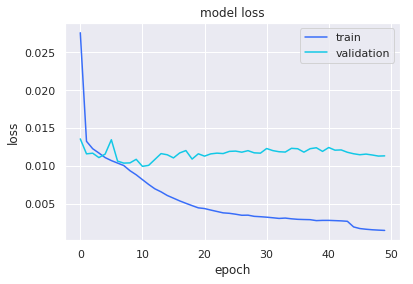

In [246]:
from keras.layers import Conv2D, Conv3D, Input, Dense
from keras.models import Model

activation = 'relu'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 2))
# 3x3 conv with 3 output channels (same as input channels)

strided0 = Conv2D(32, (3, 3), strides=2)(inputs)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
d = Dense(2048, activation=activation)(dense0)
d = Dropout(0.5)(d)
predictions = Dense(4, activation='linear')(d)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

#################################################################

model_fn = dir_name + 'models/2sig/relu_resnet_2chans.h5'
history_fn = dir_name + 'models/2sig/relu_resnet_2chans_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


relu_resnet_2chans_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)

        X1 -= np.mean(X1)
        X1 /= np.std(X1)

        X2 -= np.mean(X2, axis=0)
        X2 /= np.std(X2, axis=0)

        Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))
        
        predictions = model.predict(Xstack)[0]
        
        relu_resnet_2chans_predictions[i, j, :] = predictions
        
np.save('train/2sig/relu_resnet_2chans_predictions.npy', relu_resnet_2chans_predictions)

relu_resnet_2chans_errors = np.mean(np.mean((all_labels - relu_resnet_2chans_predictions)**2, axis=2), axis=1)

relu_resnet_2chans_errors_keep_dims = np.mean((all_labels - relu_resnet_2chans_predictions)**2, axis=2)

In [279]:
relu_resnet_2chans_predictions = np.load('train/2sig/relu_resnet_2chans_predictions.npy')
relu_resnet_2chans_errors_keep_dims = np.mean((all_labels - relu_resnet_2chans_predictions)**2, axis=2)

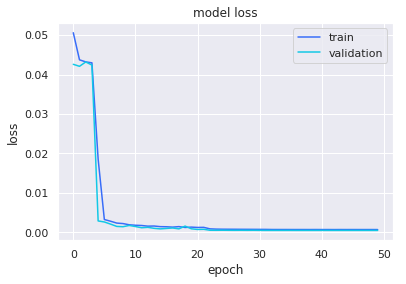

In [247]:
from keras.layers import Conv2D, Conv3D, Input, Dense
from keras.models import Model

activation = 'relu'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 2))
# 3x3 conv with 3 output channels (same as input channels)

strided0 = Conv2D(32, (3, 3), strides=2)(inputs)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(32, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 32)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(strided2)
dense0 = Dense(64, activation=activation)(flat)
d = Dense(2048, activation=activation)(dense0)
d = Dropout(0.5)(d)
predictions = Dense(4, activation='linear')(d)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

#################################################################

model_fn = dir_name + 'models/2sig/relu_resnet_2chans_bright.h5'
history_fn = dir_name + 'models/2sig/relu_resnet_2chans_bright_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


relu_resnet_2chans_bright_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)

        X1 -= np.mean(X1)
        X1 /= np.std(X1)

        X2 -= np.mean(X2, axis=0)
        X2 /= np.std(X2, axis=0)

        Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))
        
        predictions = model.predict(Xstack)[0]
        
        relu_resnet_2chans_bright_predictions[i, j, :] = predictions
        
np.save('train/2sig/relu_resnet_2chans_bright_predictions.npy', relu_resnet_2chans_bright_predictions)

relu_resnet_2chans_bright_errors = np.mean(np.mean((all_labels - relu_resnet_2chans_bright_predictions)**2, axis=2), axis=1)

relu_resnet_2chans_bright_errors_keep_dims = np.mean((all_labels - relu_resnet_2chans_bright_predictions)**2, axis=2)

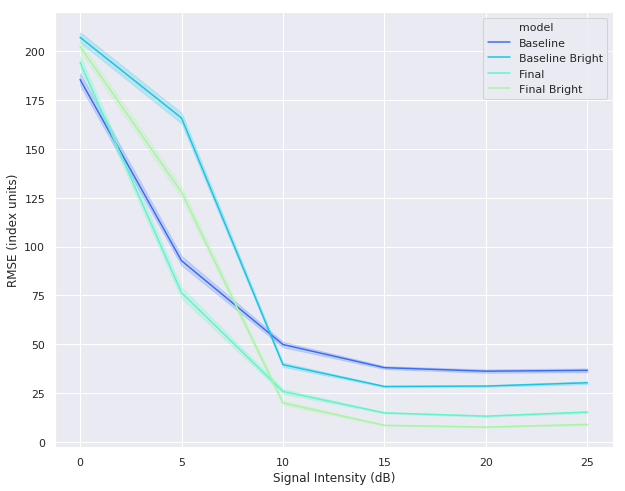

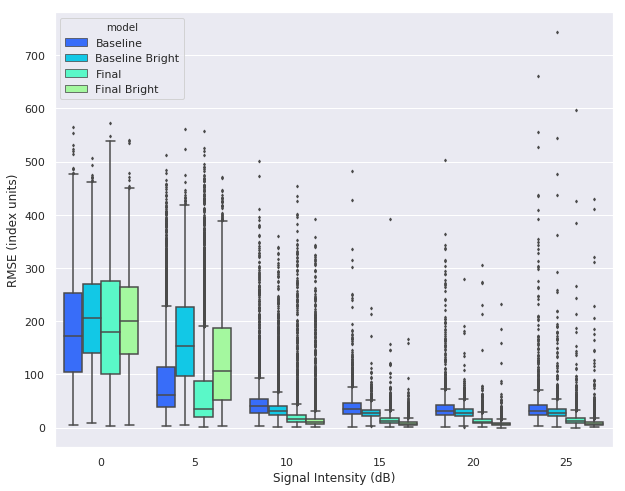

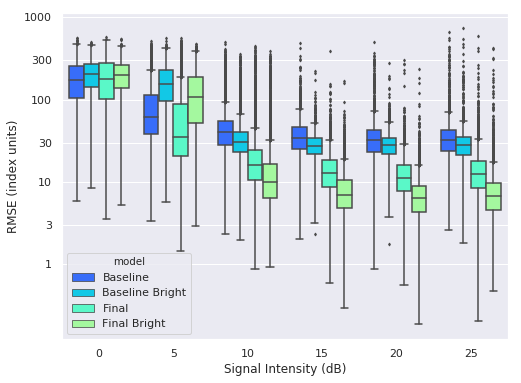

In [288]:
all_labels = np.load('train/2sig/all_labels.npy')
simple_cnn_predictions = np.load('train/2sig/simple_cnn_predictions.npy')
simple_cnn_bright_predictions = np.load('train/2sig/simple_cnn_bright_predictions.npy')
relu_resnet_2chans_predictions = np.load('train/2sig/relu_resnet_2chans_predictions.npy')
relu_resnet_2chans_bright_predictions = np.load('train/2sig/relu_resnet_2chans_bright_predictions.npy')

simple_cnn_errors_keep_dims = np.mean((all_labels - simple_cnn_predictions)**2, axis=2)
simple_cnn_bright_errors_keep_dims = np.mean((all_labels - simple_cnn_bright_predictions)**2, axis=2)
relu_resnet_2chans_errors_keep_dims = np.mean((all_labels - relu_resnet_2chans_predictions)**2, axis=2)
relu_resnet_2chans_bright_errors_keep_dims = np.mean((all_labels - relu_resnet_2chans_bright_predictions)**2, axis=2)

d = {'db': [], 'mse': [], 'rmse_index': [], 'model': []}
for i in range(6):
    for j in range(4000):
        d['db'].append(i * 5)
        d['mse'].append(simple_cnn_errors_keep_dims[i, j])
        d['rmse_index'].append(simple_cnn_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Baseline')
        
        d['db'].append(i * 5)
        d['mse'].append(simple_cnn_bright_errors_keep_dims[i, j])
        d['rmse_index'].append(simple_cnn_bright_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Baseline Bright')
        
        d['db'].append(i * 5)
        d['mse'].append(relu_resnet_2chans_errors_keep_dims[i, j])
        d['rmse_index'].append(relu_resnet_2chans_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final')
        
        d['db'].append(i * 5)
        d['mse'].append(relu_resnet_2chans_bright_errors_keep_dims[i, j])
        d['rmse_index'].append(relu_resnet_2chans_bright_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final Bright')
    
df = pd.DataFrame(data=d)

fig = plt.figure(figsize=(10, 8))
sns.lineplot(x='db', y='rmse_index', hue='model', data=df)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')
plt.show()

import matplotlib.ticker as ticker

df = pd.DataFrame(data=d)

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

# plt.ylim(0, 500)
# ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

df = pd.DataFrame(data=d)

import matplotlib.ticker as ticker

sns.set(palette="rainbow")
fig = plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

## Fine Tune VGG19

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 1024, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 1024, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 1024, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 512, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 512, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 512, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 256, 128)      0         
__________

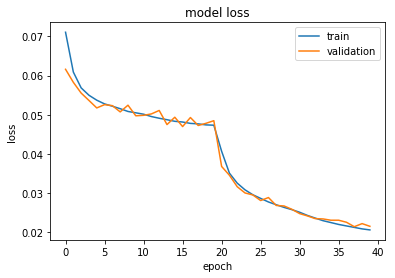

NameError: name 'pd' is not defined

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.utils import multi_gpu_model, to_categorical

import pickle

if len(sys.argv) > 1 and sys.argv[1] == '0':
    prefix = '/mnt_blpc1/datax/scratch/bbrzycki/training/training2/'
else:
    prefix = '/datax/scratch/bbrzycki/training/training2/'
    
vgg_prefix = '/datax/scratch/bbrzycki/training/training2/notebooks/'

# dimensions of our images.
img_width, img_height = 32*2, 1024

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = keras.applications.vgg19.VGG19(input_shape=(img_width, img_height, 3),
                        weights='imagenet',
                        include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a regression layer
predictions = Dense(4, activation='linear')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

def index_diff(y_true, y_pred):
    return K.mean((y_true - y_pred)**2) * 1024

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam',
              loss='mse',
              metrics=[index_diff])
model.summary()

model_fn = vgg_prefix + 'saved_models/vgg19.h5'

model.load_weights(model_fn)

all_history = []
for i in range(4):
    with open(vgg_prefix + 'saved_models/vgg19_history_%d' % (i + 1), 'rb') as f:
        all_history.append(pickle.load(f))

history = {'loss': [], 'val_loss': []}
for i in range(4):
    history['loss'].extend(all_history[i]['loss'])
    history['val_loss'].extend(all_history[i]['val_loss'])

plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()


vgg19_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)
        X3 = np.copy(X1)

        X1 -= np.mean(X1, keepdims=True)
        X1 /= np.std(X1, keepdims=True)

        X2 -= np.mean(X2, axis=0, keepdims=True)
        X2 /= np.std(X2, axis=0, keepdims=True)

        X3 -= np.mean(X3, axis=1, keepdims=True)
        X3 /= np.std(X3, axis=1, keepdims=True)


        Xstack = np.transpose(np.stack((X1, X1, X1)), (1, 2, 0))

        Xstack = np.repeat(Xstack, repeats=2, axis=0).reshape((1, 64, 1024, 3))
        
        predictions = model.predict(Xstack)[0]
        
        vgg19_predictions[i, j, :] = predictions
        
np.save('train/2sig/vgg19_predictions.npy', vgg19_predictions)

vgg19_errors = np.mean(np.mean((all_labels - vgg19_predictions)**2, axis=2), axis=1)

vgg19_errors_keep_dims = np.mean((all_labels - vgg19_predictions)**2, axis=2)

d = {'db': [], 'mse': [], 'rmse_index': [], 'model': []}
for i in range(6):
    for j in range(4000):
        d['db'].append(i * 5)
        d['mse'].append(vgg19_errors_keep_dims[i, j])
        d['rmse_index'].append(vgg19_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('VGG19')
        
df = pd.DataFrame(data=d)

fig = plt.figure(figsize=(10, 8))
sns.lineplot(x='db', y='rmse_index', hue='model', data=df)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')
plt.show()

import matplotlib.ticker as ticker

df = pd.DataFrame(data=d)

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

# plt.ylim(0, 500)
# ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

df = pd.DataFrame(data=d)

import matplotlib.ticker as ticker

sns.set(palette="rainbow")
fig = plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.savefig('2sig_rmse_vgg19.pdf', bbox_inches='tight')
plt.show()

In [11]:
import pandas as pd
import seaborn as sns

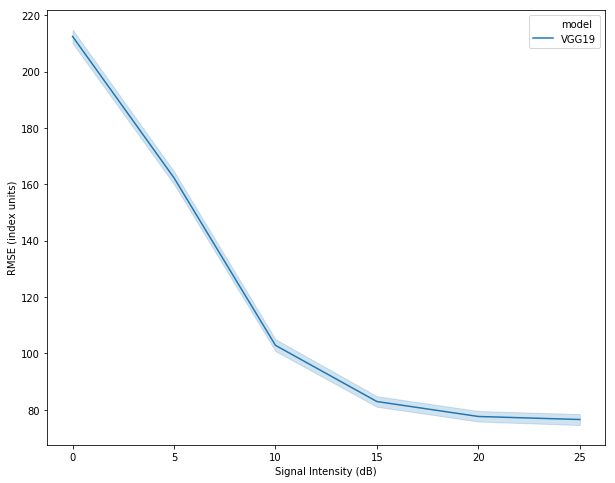

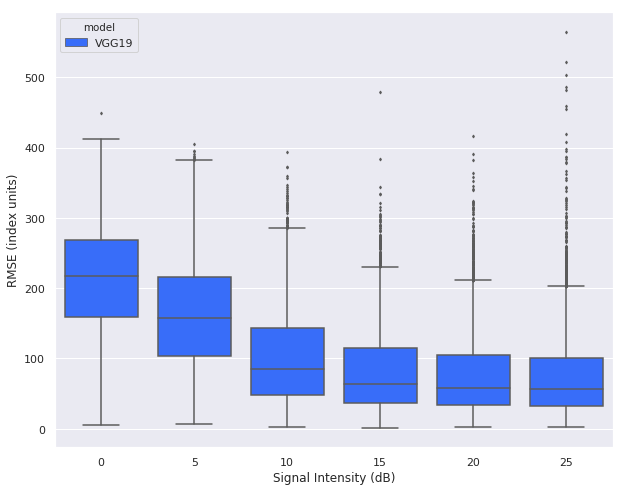

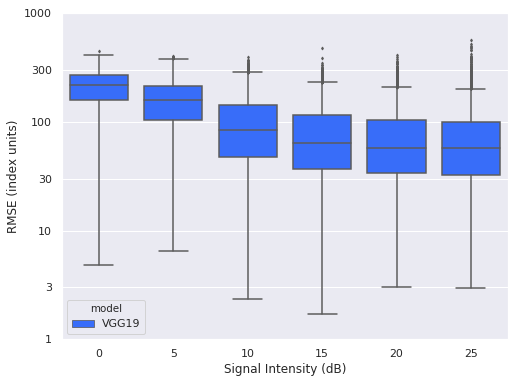

In [12]:
df = pd.DataFrame(data=d)

fig = plt.figure(figsize=(10, 8))
sns.lineplot(x='db', y='rmse_index', hue='model', data=df)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')
plt.show()

import matplotlib.ticker as ticker

df = pd.DataFrame(data=d)

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

# plt.ylim(0, 500)
# ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

df = pd.DataFrame(data=d)

import matplotlib.ticker as ticker

sns.set(palette="rainbow")
fig = plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.savefig('2sig_rmse_vgg19.pdf', bbox_inches='tight')
plt.show()

In [13]:
from keras import backend as K
K.clear_session()

In [15]:
from numba import cuda
cuda.select_device(0)
cuda.close()

ModuleNotFoundError: No module named 'numba.typeconv'

In [248]:
d = {'db': [], 'mse': [], 'rmse_index': [], 'model': []}
for i in range(6):
    for j in range(4000):
        d['db'].append(i * 5)
        d['mse'].append(simple_cnn_errors_keep_dims[i, j])
        d['rmse_index'].append(simple_cnn_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Baseline')
        
        d['db'].append(i * 5)
        d['mse'].append(simple_cnn_bright_errors_keep_dims[i, j])
        d['rmse_index'].append(simple_cnn_bright_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Baseline Bright')
        
        
        d['db'].append(i * 5)
        d['mse'].append(resnet_2chans_errors_keep_dims[i, j])
        d['rmse_index'].append(resnet_2chans_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final Tanh')
        
        d['db'].append(i * 5)
        d['mse'].append(resnet_2chans_bright_errors_keep_dims[i, j])
        d['rmse_index'].append(resnet_2chans_bright_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final Tanh Bright')
        
        d['db'].append(i * 5)
        d['mse'].append(relu_resnet_2chans_errors_keep_dims[i, j])
        d['rmse_index'].append(relu_resnet_2chans_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final Relu')
        
        d['db'].append(i * 5)
        d['mse'].append(relu_resnet_2chans_bright_errors_keep_dims[i, j])
        d['rmse_index'].append(relu_resnet_2chans_bright_errors_keep_dims[i, j]**0.5*1024)
        d['model'].append('Final Relu Bright')
    

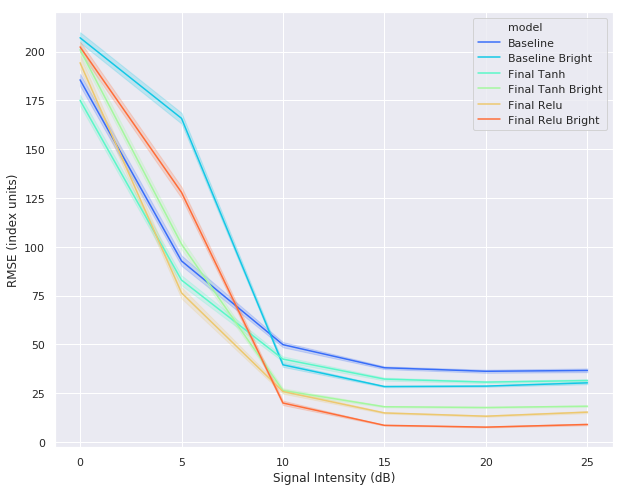

In [249]:
df = pd.DataFrame(data=d)

fig = plt.figure(figsize=(10, 8))
sns.lineplot(x='db', y='rmse_index', hue='model', data=df)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')
plt.show()

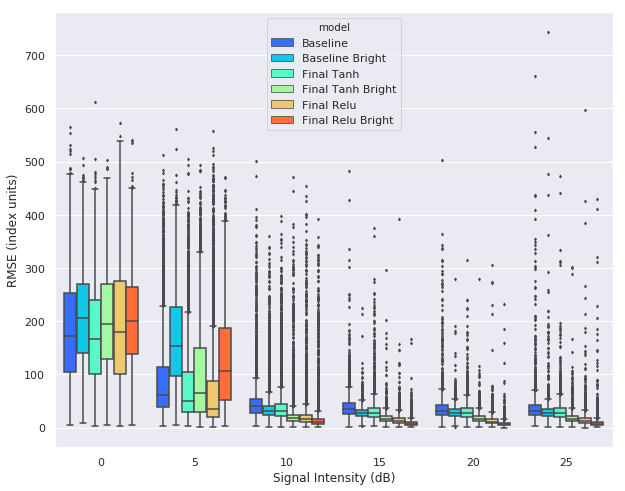

In [250]:
import matplotlib.ticker as ticker

df = pd.DataFrame(data=d)

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

# plt.ylim(0, 500)
# ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

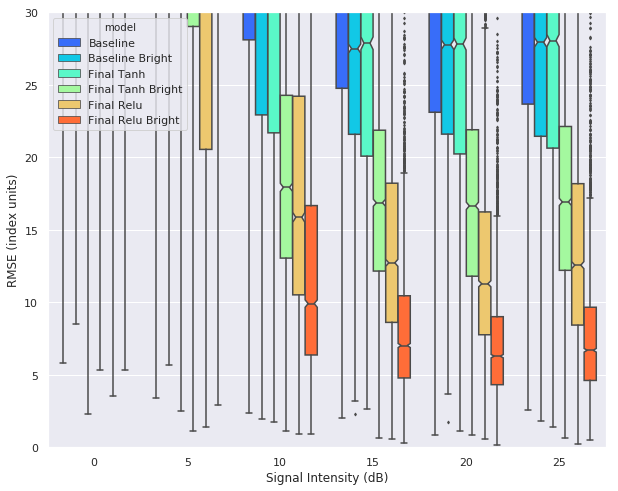

In [253]:
import matplotlib.ticker as ticker

df = pd.DataFrame(data=d)

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2, notch=True)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

plt.ylim(0, 30)
# ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

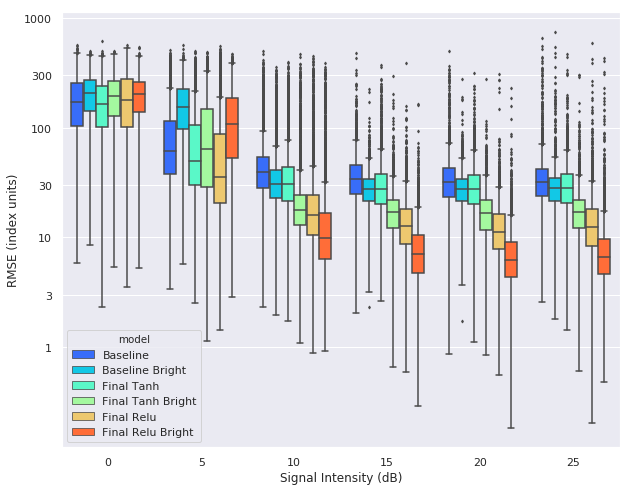

In [251]:
df = pd.DataFrame(data=d)

import matplotlib.ticker as ticker

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

Colormap fr is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [ ]:
import matplotlib.ticker as ticker

df = pd.DataFrame(data=d)

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
# plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

# plt.ylim(0, 500)
# ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

df = pd.DataFrame(data=d)

import matplotlib.ticker as ticker

sns.set(palette="rainbow")
fig = plt.figure(figsize=(10, 8))
ax = sns.boxplot(x='db', y='rmse_index', hue='model', data=df, saturation=1, fliersize=2)
plt.yscale('log')
plt.xlabel('Signal Intensity (dB)')
plt.ylabel('RMSE (index units)')

ax.set_yticks([1, 3, 10, 30, 100, 300, 1000])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

# plt.savefig('2sig_rmse.pdf', bbox_inches='tight')
plt.show()

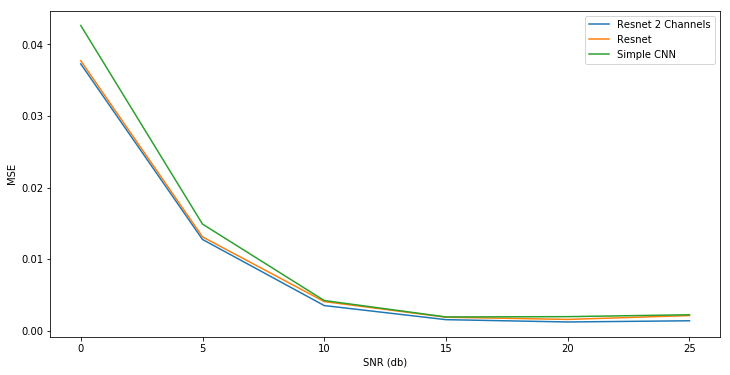

In [89]:
fig = plt.figure(figsize=(12,6))
plt.plot(dbs, resnet_2chans_errors, label='Resnet 2 Channels')
plt.plot(dbs, resnet_errors, label='Resnet')
plt.plot(dbs, simple_cnn_errors, label='Simple CNN')
plt.xlabel('SNR (db)')
plt.ylabel('MSE')
plt.legend()
plt.show()

### ResNet 2 Inputs

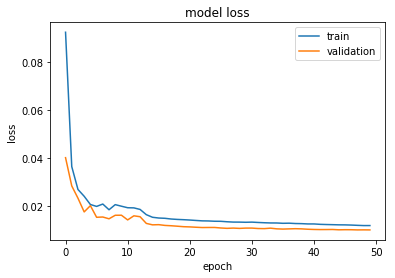

In [67]:
from keras.layers import Conv2D, Conv3D, Input, Dense
from keras.models import Model

activation = 'tanh'
def Residual(x, layers=32):
    conv = Conv2D(layers, (3, 3), padding='same')(x)
    residual =  keras.layers.add([x, conv])
    act = Activation(activation)(residual)
    normed = BatchNormalization()(act)
    return normed

inputs = Input(shape=(32, 1024, 1))
# 3x3 conv with 3 output channels (same as input channels)
r0 = Residual(inputs, 32)
strided0 = Conv2D(32, (3, 3), strides=2)(r0)
strided0 = Activation(activation)(strided0)

r1 = Residual(strided0, 32)
strided1 = Conv2D(64, (3, 3), strides=2)(r1)
strided1 = Activation(activation)(strided1)

r2 = Residual(strided1, 64)
strided2 = Conv2D(64, (3, 3), strides=2)(r2)
strided2 = Activation(activation)(strided2)


inputsx = Input(shape=(32, 1024, 1))
# 3x3 conv with 3 output channels (same as input channels)
r0x = Residual(inputsx, 32)
strided0x = Conv2D(32, (3, 3), strides=2)(r0x)
strided0x = Activation(activation)(strided0x)

r1x = Residual(strided0x, 32)
strided1x = Conv2D(64, (3, 3), strides=2)(r1x)
strided1x = Activation(activation)(strided1x)

r2x = Residual(strided1x, 64)
strided2x = Conv2D(64, (3, 3), strides=2)(r2x)
strided2x = Activation(activation)(strided2x)


x = keras.layers.concatenate([strided2, strided2x])

# a layer instance is callable on a tensor, and returns a tensor
flat = Flatten()(x)
dense0 = Dense(64, activation=activation)(flat)
dense1 = Dense(64, activation=activation)(dense0)
drop0 = Dropout(0.5)(dense1)
predictions = Dense(4, activation='linear')(drop0)

def index_diff(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred)) * 1024

model = Model(inputs=[inputs, inputsx], outputs=predictions)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[index_diff])

model_fn = dir_name + 'models/2sig/resnet_2inputs.h5'
history_fn = dir_name + 'models/2sig/resnet_2inputs_history'

model.load_weights(model_fn)
with open(history_fn, 'rb') as f:
    history = pickle.load(f)
    
plt.plot(history['loss'], )
plt.plot(history['val_loss'], )
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [68]:
resnet_2inputs_predictions = np.zeros(sig_shape)

for i in range(db_num):
    sig_db = i * 5

    for j in range(per_db):
        ID_int = i * per_db + j

        ID = '%06d' % ID_int

        filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
        X1 = np.load(filename)
        X2 = np.copy(X1)

        X1 -= np.mean(X1)
        X1 /= np.std(X1)

        X2 -= np.mean(X2, axis=0)
        X2 /= np.std(X2, axis=0)

        X = [X1.reshape((1, 32, 1024, 1)), X2.reshape((1, 32, 1024, 1))]
        
        predictions = model.predict(X)[0]
        
        resnet_2inputs_predictions[i, j, :] = predictions
        
resnet_2inputs_predictions.shape

(6, 4000, 4)

In [90]:
np.save('train/2sig/resnet_2inputs_predictions.npy', resnet_2inputs_predictions)

In [91]:
resnet_2inputs_errors = np.mean(np.mean((all_labels - resnet_2inputs_predictions)**2, axis=2), axis=1)
resnet_2inputs_errors.shape

(6,)

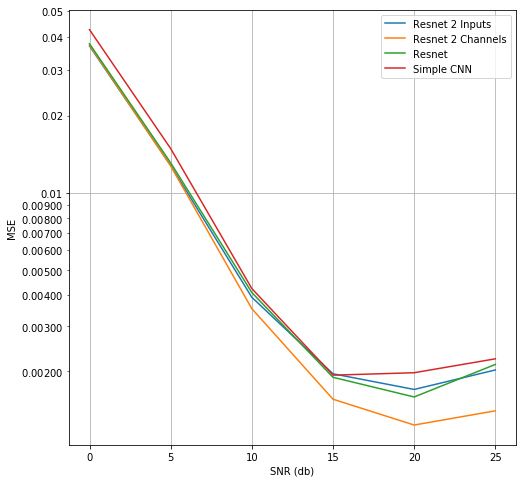

In [112]:
fig = plt.figure(figsize=(8, 8))
plt.plot(dbs, resnet_2inputs_errors, label='Resnet 2 Inputs')
plt.plot(dbs, resnet_2chans_errors, label='Resnet 2 Channels')
plt.plot(dbs, resnet_errors, label='Resnet')
plt.plot(dbs, simple_cnn_errors, label='Simple CNN')
plt.xlabel('SNR (db)')
plt.ylabel('MSE')
plt.legend()
plt.yscale('logit')
plt.show()

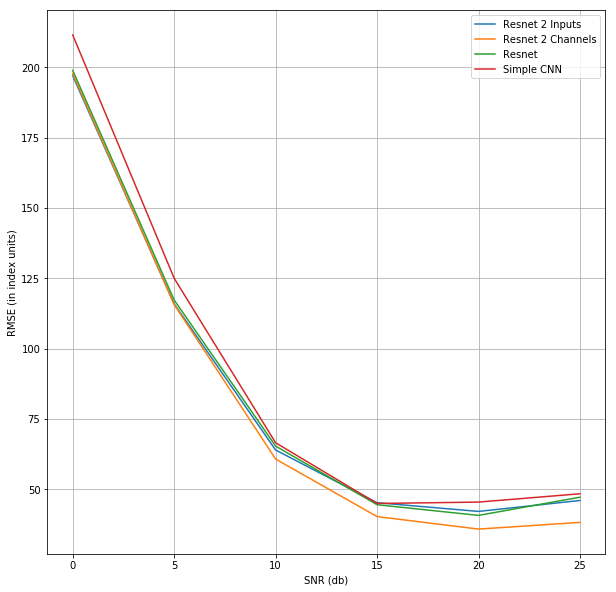

In [115]:
fig = plt.figure(figsize=(10, 10))
plt.plot(dbs, resnet_2inputs_errors**0.5*1024, label='Resnet 2 Inputs')
plt.plot(dbs, resnet_2chans_errors**0.5*1024, label='Resnet 2 Channels')
plt.plot(dbs, resnet_errors**0.5*1024, label='Resnet')
plt.plot(dbs, simple_cnn_errors**0.5*1024, label='Simple CNN')
plt.xlabel('SNR (db)')
plt.ylabel('RMSE (in index units)')
# plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

[0.23730469 0.23730469 0.81054688 0.05175781]
[0.21540383 0.21540385 0.7670922  0.09233528]
[243. 243. 830.  53.]
[221. 221. 786.  95.]
15


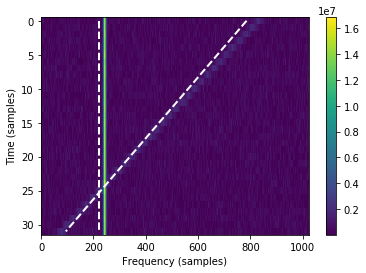

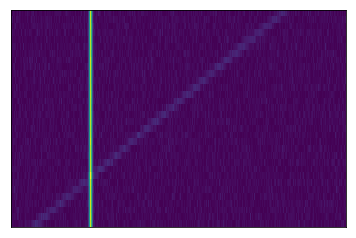

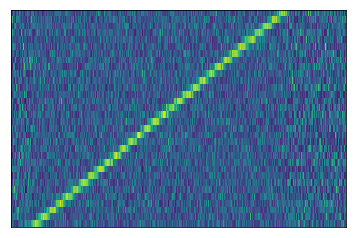

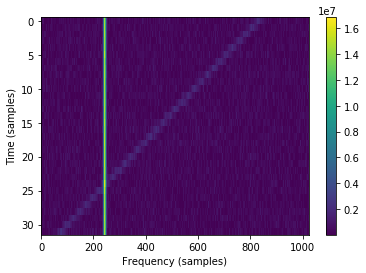

In [6]:
ID = '015012'

with h5py.File(h5_datasets, 'r') as f:
    filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
    frame = np.load(filename)
    X1 = np.copy(frame)
    X2 = np.copy(frame)

    X1 -= np.mean(X1)
    X1 /= np.std(X1)

    X2 -= np.mean(X2, axis=0)
    X2 /= np.std(X2, axis=0)

    Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))

    prediction = model.predict(Xstack)[0]
    
    sig_db = f['test'][ID].attrs['sig_db']

    start1, end1, lw1, snr1, label1, start2, end2, lw2, snr2, label2  = np.array(f['test'][ID]['signals_info']).flatten()
    # All between 0 and 1
    label = np.array([start1 / 1024, end1 / 1024, start2 / 1024, end2 / 1024])

print(label)
print(prediction)
print(label*1024)
print(np.round(prediction*1024))
print(sig_db)
    
    
# fig = plt.figure(figsize=(12,6))
plt.imshow(frame, aspect='auto')
plt.plot([prediction[0] * 1024, prediction[1] * 1024], [0, 31], 'w', linestyle='--', lw=2)
plt.plot([prediction[2] * 1024, prediction[3] * 1024], [0, 31], 'w', linestyle='--', lw=2)


# plt.plot([label[0] * 1024, label[1] * 1024], [0, 32], 'w--', lw=2)
# plt.plot([label[2] * 1024, label[3] * 1024], [0, 32], 'w--', lw=2)
plt.xlabel('Frequency (samples)')
plt.ylabel('Time (samples)')
plt.colorbar()
plt.savefig('images/predicted_overlay.pdf', bbox_inches='tight')
plt.show()

# fig = plt.figure(figsize=(12,6))
plt.imshow(X1.reshape(32, 1024), aspect='auto')
# plt.xlabel('Frequency (samples)')
# plt.ylabel('Time (samples)')
# plt.colorbar()
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelleft=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig('images/normalization1_stripped.pdf', bbox_inches='tight')
plt.show()

# fig = plt.figure(figsize=(12,6))
plt.imshow(X2.reshape(32, 1024), aspect='auto')
# plt.xlabel('Frequency (samples)')
# plt.ylabel('Time (samples)')
# plt.colorbar()
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelleft=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig('images/normalization2_stripped.pdf', bbox_inches='tight')
plt.show()

# fig = plt.figure(figsize=(12,6))
plt.imshow(frame, aspect='auto')
plt.xlabel('Frequency (samples)')
plt.ylabel('Time (samples)')
plt.colorbar()
plt.savefig('images/original.pdf', bbox_inches='tight')
plt.show()


/home/bryanb/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/bryanb/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


[0.23730469 0.23730469 0.81054688 0.05175781]
[0.2384342  0.23843443 0.7911763  0.0525662 ]
[243. 243. 830.  53.]
[244. 244. 810.  54.]
15


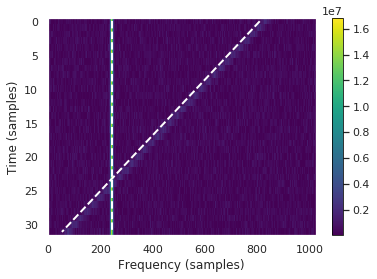

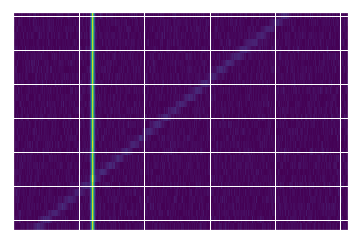

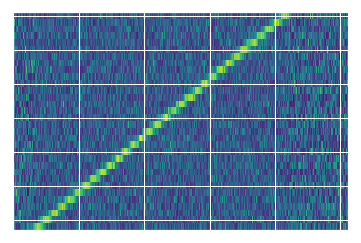

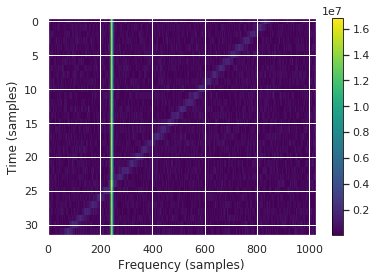

In [261]:
import importlib
import matplotlib

plt.grid(False)
sns.reset_orig()
ID = '015012'

with h5py.File(h5_datasets, 'r') as f:
    filename = '/datax/scratch/bbrzycki/training/training2/data/2sig/test/%s.npy' % ID
    frame = np.load(filename)
    X1 = np.copy(frame)
    X2 = np.copy(frame)

    X1 -= np.mean(X1)
    X1 /= np.std(X1)

    X2 -= np.mean(X2, axis=0)
    X2 /= np.std(X2, axis=0)

    Xstack = np.transpose(np.stack((X1, X2)), (1, 2, 0)).reshape((1, 32, 1024, 2))

    prediction = model.predict(Xstack)[0]
    
    sig_db = f['test'][ID].attrs['sig_db']

    start1, end1, lw1, snr1, label1, start2, end2, lw2, snr2, label2  = np.array(f['test'][ID]['signals_info']).flatten()
    # All between 0 and 1
    label = np.array([start1 / 1024, end1 / 1024, start2 / 1024, end2 / 1024])

print(label)
print(prediction)
print(label*1024)
print(np.round(prediction*1024))
print(sig_db)
    
    
# fig = plt.figure(figsize=(12,6))
plt.imshow(frame, aspect='auto')
plt.plot([prediction[0] * 1024, prediction[1] * 1024], [0, 31], 'w', linestyle='--', lw=2)
plt.plot([prediction[2] * 1024, prediction[3] * 1024], [0, 31], 'w', linestyle='--', lw=2)


# plt.plot([label[0] * 1024, label[1] * 1024], [0, 32], 'w--', lw=2)
# plt.plot([label[2] * 1024, label[3] * 1024], [0, 32], 'w--', lw=2)
plt.xlabel('Frequency (samples)')
plt.ylabel('Time (samples)')
plt.colorbar()
plt.savefig('images/predicted_overlay_relu_bright.pdf', bbox_inches='tight')
plt.show()

# fig = plt.figure(figsize=(12,6))
plt.imshow(X1.reshape(32, 1024), aspect='auto')
# plt.xlabel('Frequency (samples)')
# plt.ylabel('Time (samples)')
# plt.colorbar()
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelleft=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig('images/normalization1_stripped.pdf', bbox_inches='tight')
plt.show()

# fig = plt.figure(figsize=(12,6))
plt.imshow(X2.reshape(32, 1024), aspect='auto')
# plt.xlabel('Frequency (samples)')
# plt.ylabel('Time (samples)')
# plt.colorbar()
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelleft=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig('images/normalization2_stripped.pdf', bbox_inches='tight')
plt.show()

# fig = plt.figure(figsize=(12,6))
plt.imshow(frame, aspect='auto')
plt.xlabel('Frequency (samples)')
plt.ylabel('Time (samples)')
plt.colorbar()
plt.savefig('images/original.pdf', bbox_inches='tight')
plt.show()
